In [32]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import math

import torch
from torchdiffeq import odeint

import main as m
import utils as u
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
torch.cat([torch.tensor([0.]),torch.logspace(-1,2,20)])

tensor([  0.0000,   0.1000,   0.1438,   0.2069,   0.2976,   0.4281,   0.6158,
          0.8859,   1.2743,   1.8330,   2.6367,   3.7927,   5.4556,   7.8476,
         11.2884,  16.2378,  23.3572,  33.5982,  48.3293,  69.5193, 100.0000])

In [190]:
ts = torch.cat([torch.tensor([0.]),torch.logspace(-1,2,20)])
n_vars = 2
batch_size = 1000
d_model = 60
noise_std_ratio = 0.1


torch.Size([1000, 21, 2])

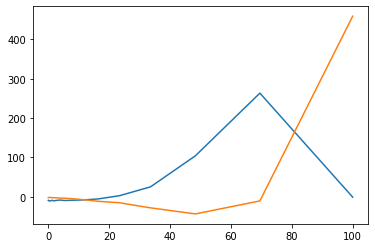

In [191]:
theta, sample = m.solve_ode_sample(batch_size, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts, device='cuda')
plt.plot(ts, sample[0].to('cpu').reshape(len(ts), n_vars))
sample.shape

In [205]:
%%time
obs_to_embed = u.MLP(input_size=n_vars,output_size=d_model,num_hidden_layers=1,num_hidden_units=d_model*2, unsqueeze=False)


obs_to_embed = m.SeqPosteriorTransformer(obs_embedder=obs_to_embed,
                                         d_model=d_model,
                                         num_transformer_layers=1,
                                         positional_encoding=True,
                                         decode_length=3)

inference_network = m.GaussianMixturePosterior(obs_to_embed= obs_to_embed,
                                               num_latents= n_vars**2).cuda()

optimizer = torch.optim.Adam(params=inference_network.parameters())

gen_traces_fn = lambda: m.solve_ode_sample(batch_size, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                          device='cuda')

losses = m.amortize_inference(inference_network, gen_traces_fn, optimizer, 500)

CPU times: user 39.6 s, sys: 543 ms, total: 40.1 s
Wall time: 40.9 s


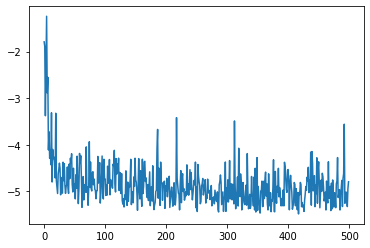

In [206]:
plt.plot(losses)

In [218]:
theta, sample = m.solve_ode_sample(1, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                       device='cuda')
print(theta)
posterior = inference_network.get_q_x_given_seqembed(inference_network.obs_to_embed(sample[:1]))
torch.abs(posterior.multivariatenormals.sample((1000,)).reshape(-1,2,2)).mean(dim=0)

tensor([[-0.0855, -0.0257],
        [ 0.0777,  0.0730]], device='cuda:0')


tensor([[0.0797, 0.0818],
        [0.0829, 0.0858]], device='cuda:0')

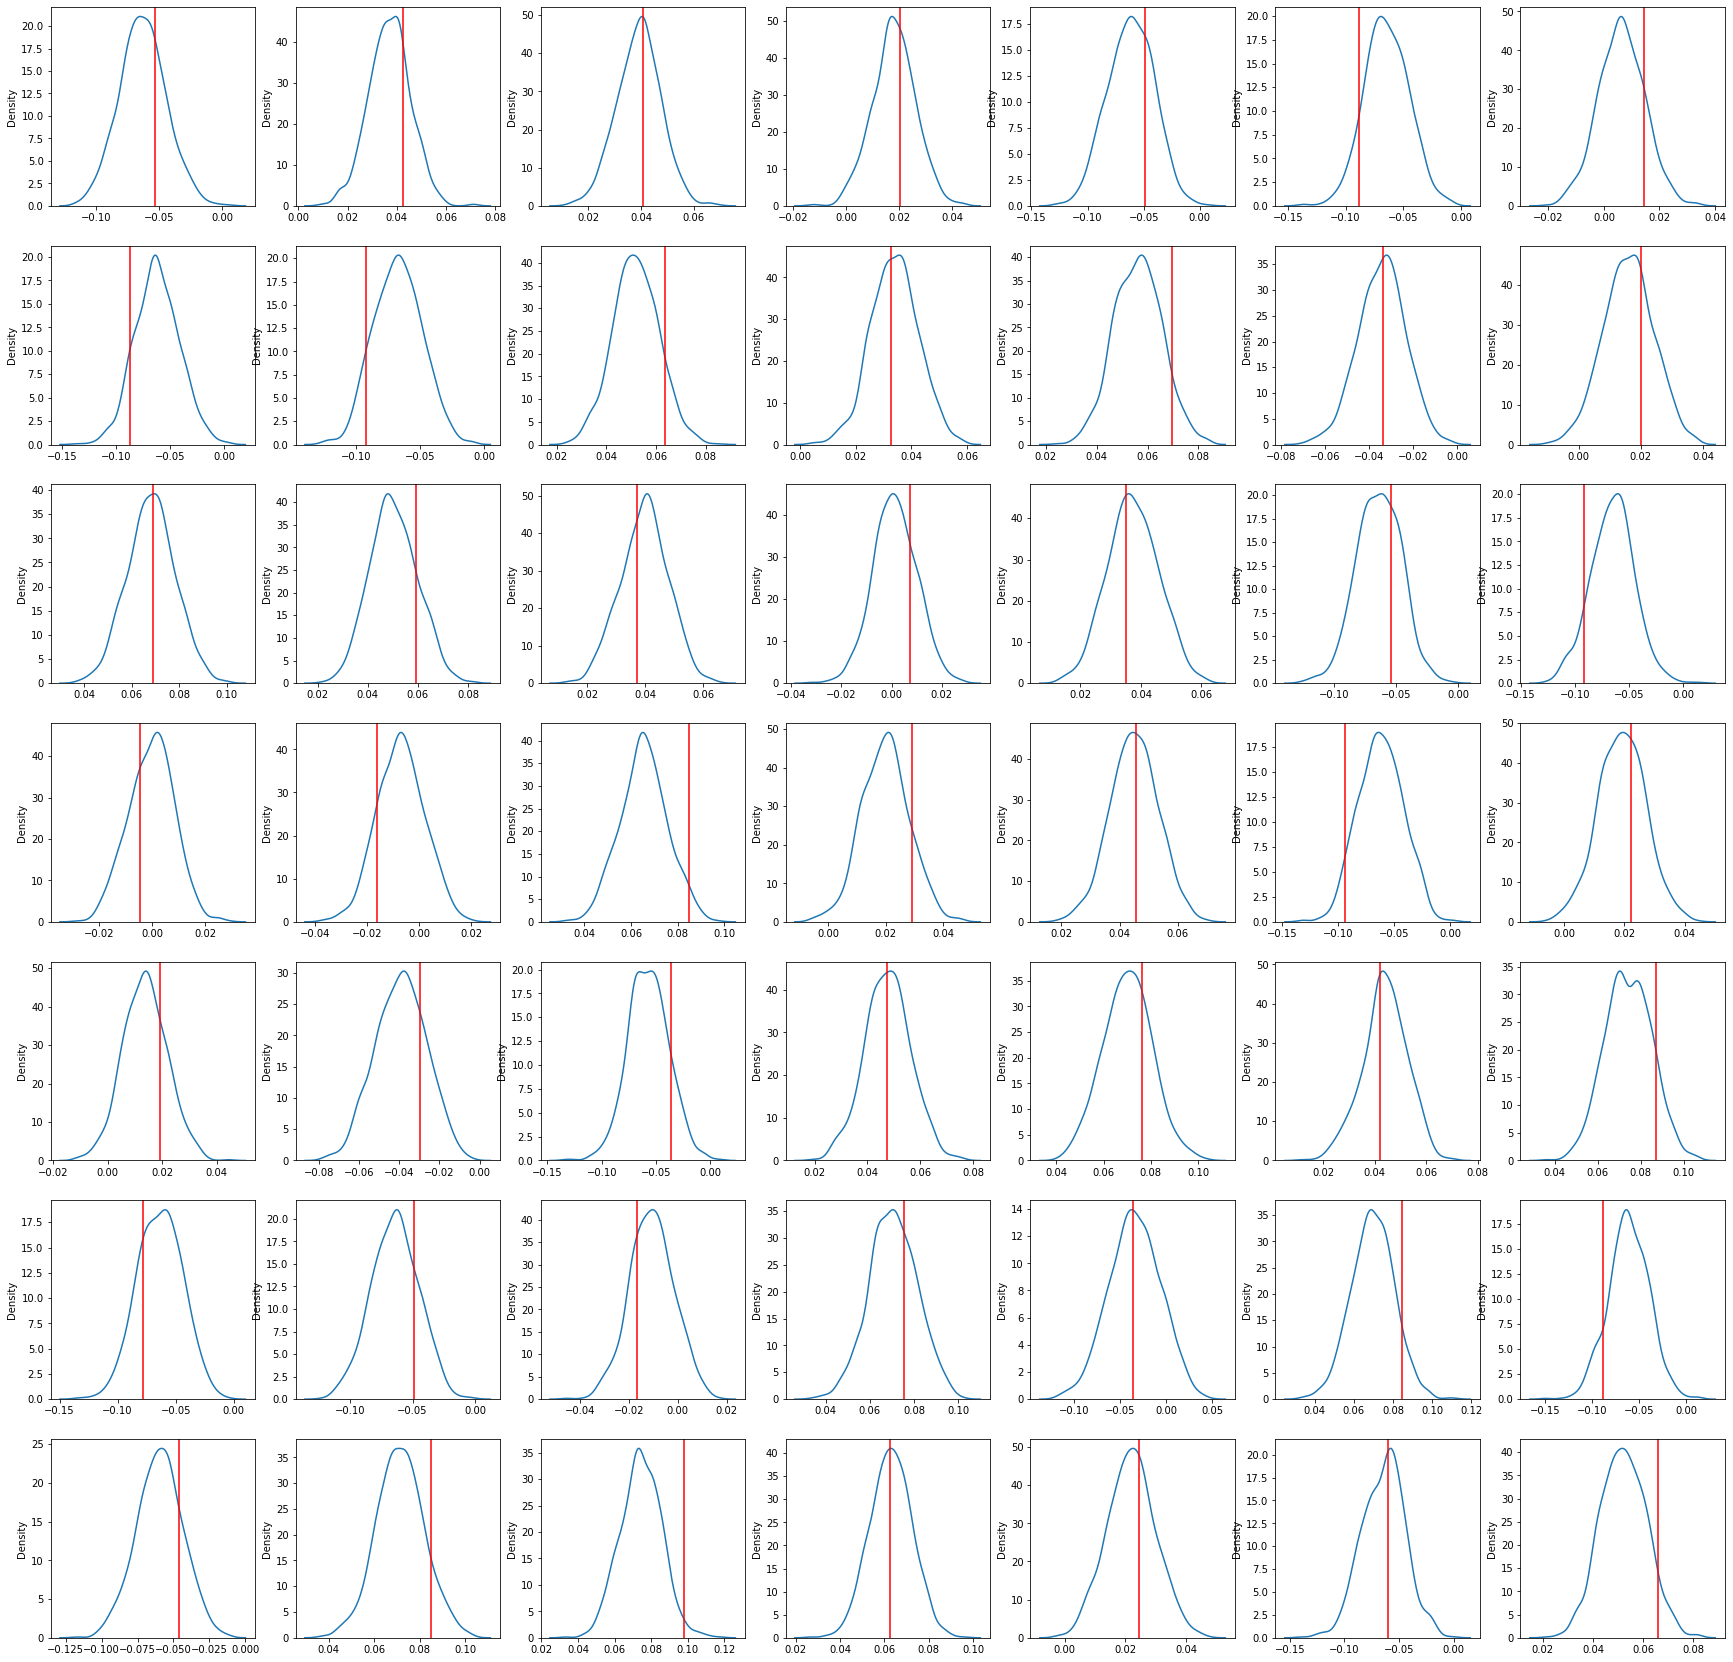

In [100]:
num_plots = 49
num_cols = 7
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30))
for i in range(num_plots):
    theta, sample = m.solve_ode_sample(1, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                       device='cuda')
    c = i % num_cols
    r = math.floor(i/num_cols)
    dist = inference_network.get_q_x_given_obs(sample[0:1])
    sns.kdeplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
                                   means=dist.normals.loc[0], 
                                   stds=dist.normals.scale[0]).sample(1000).to('cpu'),
                ax=axes[r,c])
    axes[r,c].axvline(theta[0].to('cpu').item(), color='red')


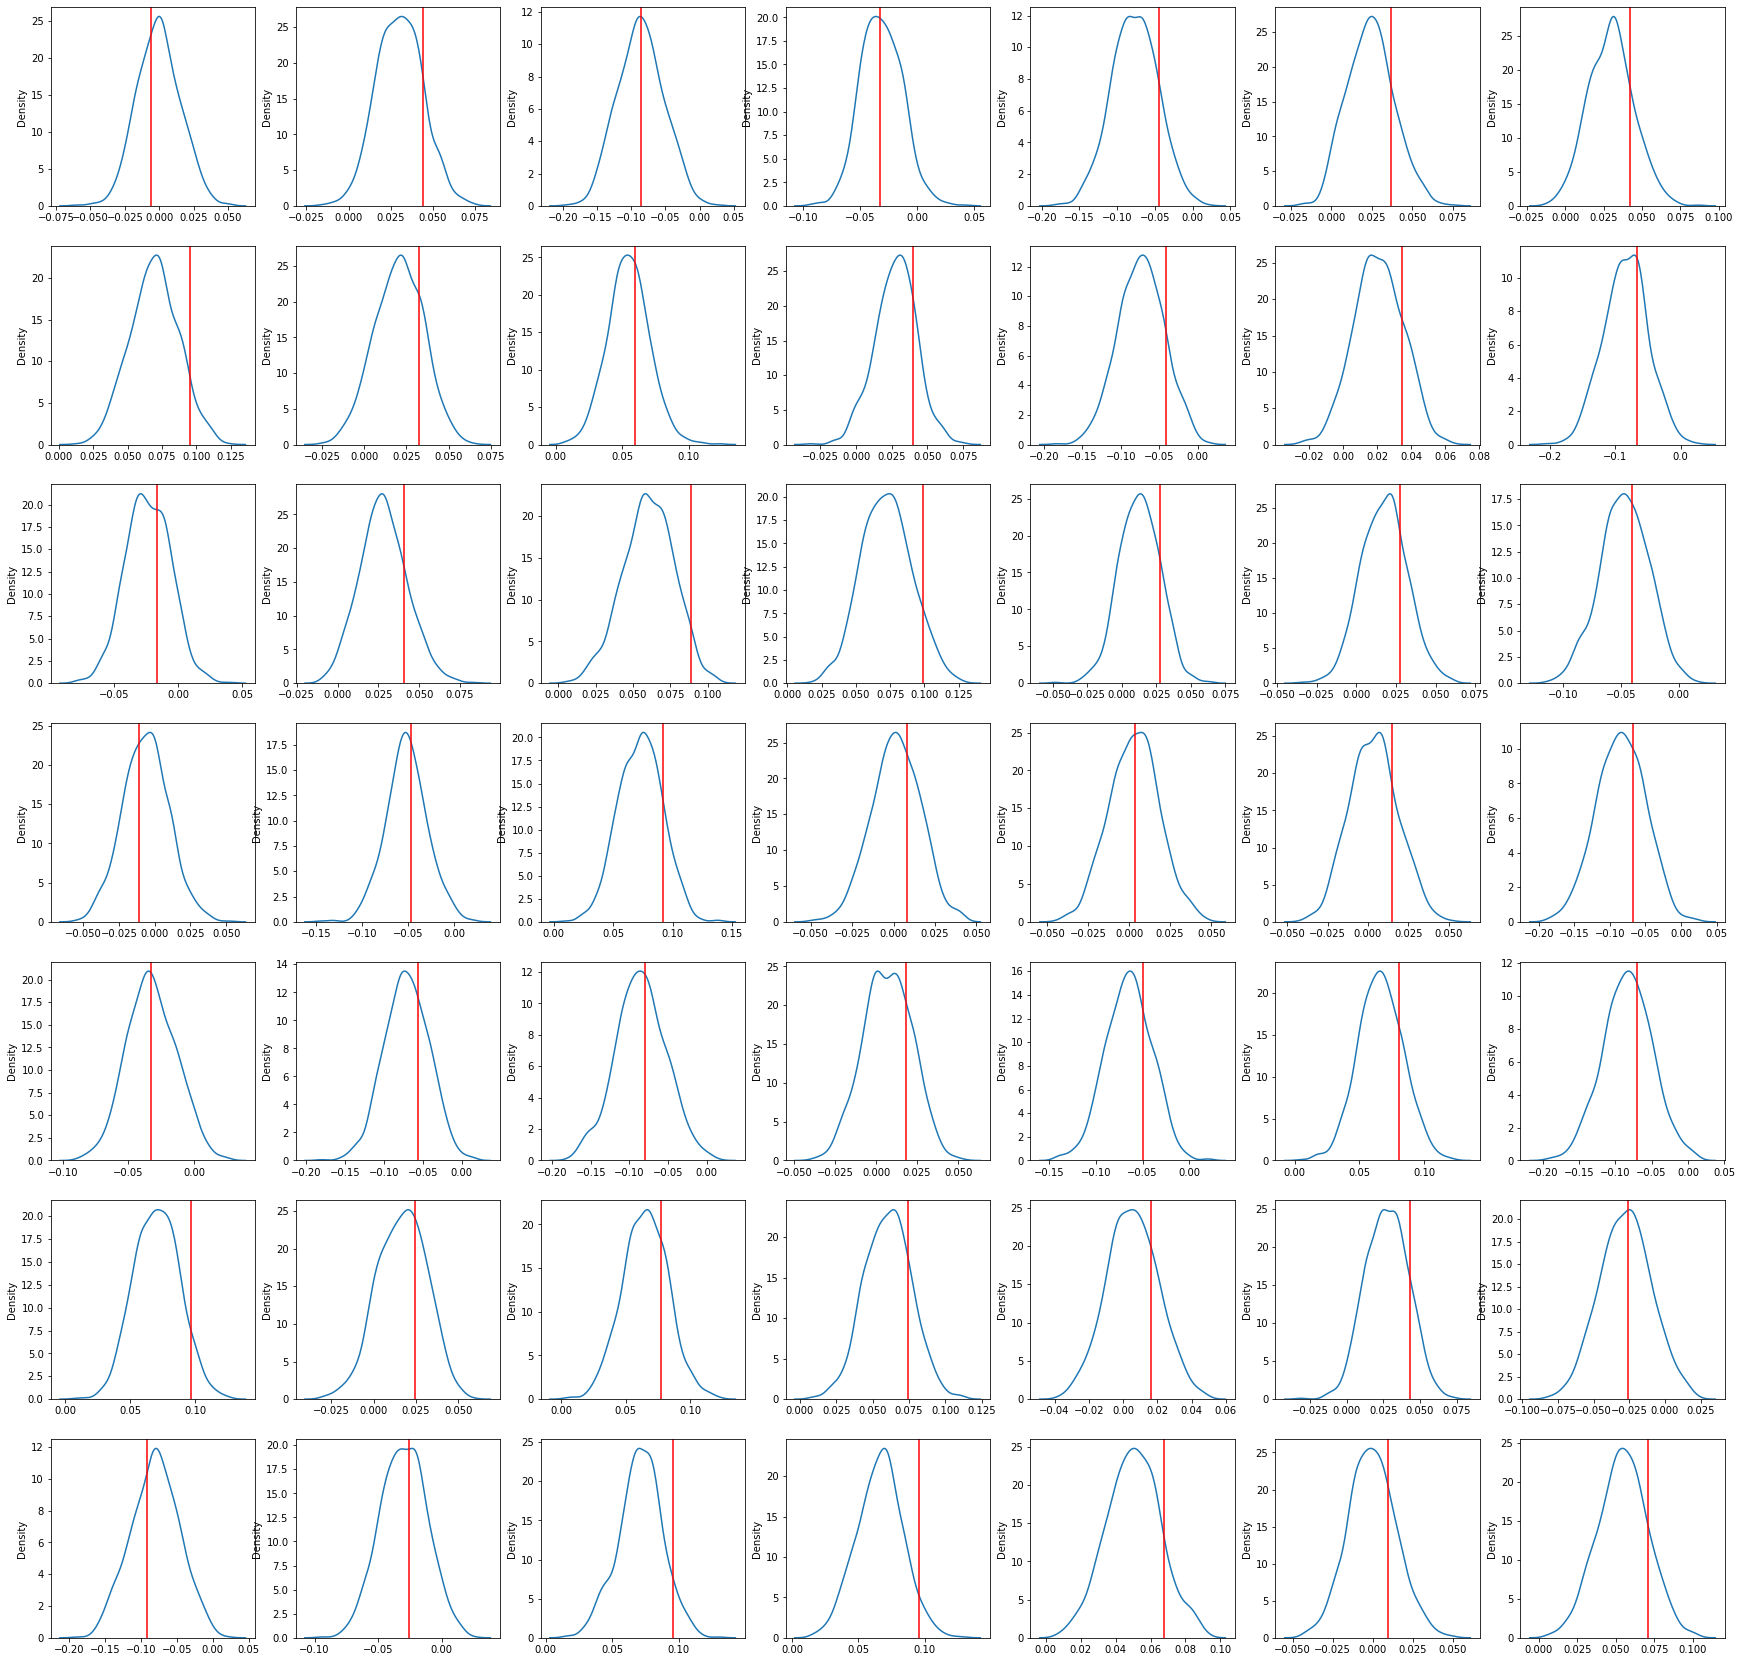

In [117]:
num_plots = 49
num_cols = 7
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30))
for i in range(num_plots):
    theta, sample = m.solve_ode_sample(1, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                       device='cuda')
    c = i % num_cols
    r = math.floor(i/num_cols)
    dist = inference_network.get_q_x_given_obs(sample[0:1])
    sns.kdeplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
                                   means=dist.normals.loc[0], 
                                   stds=dist.normals.scale[0]).sample(1000).to('cpu'),
                ax=axes[r,c])
    axes[r,c].axvline(theta[0].to('cpu').item(), color='red')
